In [18]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,Literal,Annotated 
from langchain_core.messages import BaseMessage, HumanMessage 
from langchain_google_genai import ChatGoogleGenerativeAI 
from langgraph.graph.message import add_messages 
from langgraph.prebuilt import ToolNode, tools_condition 
from langchain_community.tools import DuckDuckGoSearchRun 
from dotenv import load_dotenv 
from langchain_core.tools import tool 
from langgraph.checkpoint.sqlite import SqliteSaver


import sqlite3 
import requests 
import os 

load_dotenv()

True

## LLM

In [11]:
os.environ['GOOGLE_API_KEY'] = os.getenv('gemini_api_key') 
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

## Defining Tools

In [19]:
from langchain_tavily import TavilySearch 

search_tool = TavilySearch(max_result=2) 

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}




@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()



tools = [search_tool, get_stock_price, calculator]
llm_with_tools = llm.bind_tools(tools)

## State

In [20]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages] 


## Node 
def chat_node(state:ChatState):
    """LLM Node that answers or request a tool call""" 
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]} 

tool_node = ToolNode(tools = [search_tool, get_stock_price, calculator]) 


## Chechpointer 
conn = sqlite3.connect(database="chatbot.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [21]:
graph = StateGraph(ChatState) 

graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node)

graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node", tools_condition) 
graph.add_edge("tools","chat_node") 

chatbot = graph.compile(checkpointer=checkpointer)

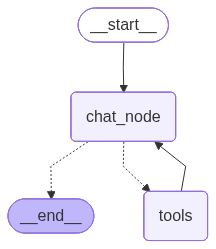

In [22]:
graph.compile(checkpointer=checkpointer)

In [26]:
import uuid  
config = {"configurable": {"thread_id": str(uuid.uuid4() )}}


In [28]:
chatbot.invoke(
    {"messages": "what is today's new of India"},
    config=config
)


{'messages': [HumanMessage(content='Add 1 and 1000', additional_kwargs={}, response_metadata={}, id='9090d827-1e61-4398-8007-8b009c8b1288'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"first_num": 1, "second_num": 1000, "operation": "add"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--fe967c4b-551c-46c8-a186-10a1b8f83bd9-0', tool_calls=[{'name': 'calculator', 'args': {'first_num': 1, 'second_num': 1000, 'operation': 'add'}, 'id': 'f28258dd-7928-4cc5-9a11-e4f4caf4ad28', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1667, 'output_tokens': 93, 'total_tokens': 1760, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 63}}),
  ToolMessage(content='{"first_num": 1.0, "second_num": 1000.0, "operation": "add", "result": 1001.0}', name='calculator', id='29d4a3ef-86ec-44e7-94ac

In [29]:
conn.close()
